In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
from scipy.stats import linregress

In [7]:
fire_df = pd.read_csv("Resources/fire_data/fire_all_grouped.csv", index_col="City_ID")
fire_df.head()

# fire_duplicates = fire_df[['Year','Month', 'County']].duplicated()
# fire_df[fire_duplicates]

#THERE ARE MULTIPLE FIRES IN YEAR/MONTH/COUNTY. 
#Therefore you need to group by month and summarize the data per month.

#select columns
fires = fire_df[["Name","Year", "Month","Month created (num)", "County", "Acres burned", "Duration (days)"]]

#drop "days" and concert to int
fires.loc[:, "Duration (days)"] = pd.to_numeric(fires["Duration (days)"].str.extract('(\d+)')[0], errors="coerce")

fires

,Year,Month,Month created (num),County,Acres Burned Avg,Acres Burned Tot,Fire Duration Avg (days),Incident Count Tot
City_ID,,,,,,,,
3,2013,April,4,Madera,274.0,274.0,1.000000,1
4,2013,April,4,Napa,75.0,75.0,1.000000,1
5,2013,April,4,San Bernardino,30.0,30.0,2.000000,1
6,2013,August,8,Butte,812.0,2436.0,3.333333,3
7,2013,August,8,Calaveras,46.0,46.0,2.000000,1


In [ ]:
fire_duplicate_df = fires.loc[fires['County'].str.contains(','), :]
fire_duplicate_df.head()

In [5]:
def expand_counties(row):
    counties = row['County'].split(", ")
    num_counties = len(counties)
    # Create new row for each county with the duration unchanged
    return [
        {**row, 'County': county, 'Acres burned': row['Acres burned'] / num_counties, 'Duration (days)': row['Duration (days)']}
        for county in counties
    ]

# Apply the function to each row and expand into a list of dictionaries
expanded_rows = [new_row for index, row in fire_duplicate_df.iterrows() for new_row in expand_counties(row)]

# Convert the list of dictionaries to a DataFrame
temp_df = pd.DataFrame(expanded_rows)

# Preview the DataFrame to confirm the changes
temp_df

,Name,Year,Month,Month created (num),County,Acres burned,Duration (days)
0,Grand Fire,2013,May,5,Kern,2173.0,6
1,Grand Fire,2013,May,5,Ventura,2173.0,6
2,Sonoma-Lake-Napa Unit Lightning Fires,2013,June,6,Sonoma,7.0,4
3,Sonoma-Lake-Napa Unit Lightning Fires,2013,June,6,Solano,7.0,4
4,Sonoma-Lake-Napa Unit Lightning Fires,2013,June,6,Lake,7.0,4
...,...,...,...,...,...,...,...
94,Fremont Fire,2021,September,9,Sonoma,58.0,1
95,Mosquito Fire,2022,September,9,El Dorado,38394.0,46
96,Mosquito Fire,2022,September,9,Placer,38394.0,46
97,Vineyard Fire,2023,July,7,Monterey,196.0,1


In [6]:
#set of counties to drop
counties_to_drop = set(fire_duplicate_df['County'])

#rows where the 'County' is not in the counties_to_drop
mask = ~fires['County'].isin(counties_to_drop)

#apply the mask to the df to filter out unwanted rows
fire_data = fires[mask]

## confirmed original number of rows 1943 - 39 duplicate rows is 1904

#add rows
comprehensive_fires = pd.concat([fire_data, temp_df], axis=0, ignore_index=True)
comprehensive_fires

#99+1904 =2003

,Name,Year,Month,Month created (num),County,Acres burned,Duration (days)
0,Bridge Fire,2017,October,10,Shasta,37.0,70
1,Pala Fire,2009,May,5,San Diego,122.0,1
2,River Fire,2013,February,2,Inyo,407.0,4
3,Fawnskin Fire,2013,April,4,San Bernardino,30.0,2
4,Gold Fire,2013,April,4,Madera,274.0,1
...,...,...,...,...,...,...,...
1998,Fremont Fire,2021,September,9,Sonoma,58.0,1
1999,Mosquito Fire,2022,September,9,El Dorado,38394.0,46
2000,Mosquito Fire,2022,September,9,Placer,38394.0,46
2001,Vineyard Fire,2023,July,7,Monterey,196.0,1


In [7]:
#groupby
fire_grouped=comprehensive_fires.groupby(['Year','Month','Month created (num)', 'County'])

fire_grouped.head()

#calc acres avg
acres_burned_avg = fire_grouped["Acres burned"].mean()

#calc rounded avg days
duration_days_avg = fire_grouped["Duration (days)"].mean()

#sum count of incidents
tot_fire_incidents = fire_grouped["Acres burned"].count()

summary_fire = pd.DataFrame({
    "Acres Burned Avg": acres_burned_avg,
    "Fire Duration Avg (days)": duration_days_avg,
    "Incident Count Tot": tot_fire_incidents
 })

summary_fire = summary_fire.reset_index()
summary_fire
#drop 2024 and 1969
final_fire = summary_fire.loc[(summary_fire["Year"]>=2013) & (summary_fire["Year"]<2024)]
final_fire

,Year,Month,Month created (num),County,Acres Burned Avg,Fire Duration Avg (days),Incident Count Tot
3,2013,April,4,Madera,274.0,1.0,1
4,2013,April,4,Napa,75.0,1.0,1
5,2013,April,4,San Bernardino,30.0,2.0,1
6,2013,August,8,Butte,812.0,3.333333,3
7,2013,August,8,Calaveras,46.0,2.0,1
...,...,...,...,...,...,...,...
1167,2023,October,10,Solano,36.0,3.0,1
1168,2023,September,9,Calaveras,32.0,2.0,1
1169,2023,September,9,Kern,55.0,1.0,1
1170,2023,September,9,Lake,28.0,5.0,1


In [8]:
final_fire.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1169 entries, 3 to 1171
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      1169 non-null   int64  
 1   Month                     1169 non-null   object 
 2   Month created (num)       1169 non-null   int64  
 3   County                    1169 non-null   object 
 4   Acres Burned Avg          1169 non-null   float64
 5   Fire Duration Avg (days)  1169 non-null   object 
 6   Incident Count Tot        1169 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 73.1+ KB


In [9]:
rainfall_df = pd.read_csv("Resources/weather_data/rainfall_all_years_clean.csv", index_col="City_ID")
filtered_rain = rainfall_df[["County", "Year", "Month", "Rainfall (inches)"]]
filtered_rain.head()

# rain_duplicates = filtered_rain.duplicated()
# print(filtered_rain[rain_duplicates])
# NO DUPLICATES

,County,Year,Month,Rainfall (inches)
City_ID,,,,
0,Alameda,2013,March,0.63
1,Alpine,2013,March,2.56
2,Amador,2013,March,2.89
3,Butte,2013,March,2.57
4,Calaveras,2013,March,2.75


In [10]:
filtered_rain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7830 entries, 0 to 7829
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   County             7830 non-null   object 
 1   Year               7830 non-null   int64  
 2   Month              7830 non-null   object 
 3   Rainfall (inches)  7830 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 305.9+ KB


In [11]:
temperature_df = pd.read_csv("Resources/weather_data/temperature_all_years_clean.csv", index_col="City_ID")
filtered_temp=temperature_df[["County", "Year", "Month", "Temperature (F)"]]

In [12]:
filtered_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7772 entries, 0 to 7771
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   County           7772 non-null   object 
 1   Year             7772 non-null   int64  
 2   Month            7772 non-null   object 
 3   Temperature (F)  7772 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 303.6+ KB


In [1]:
temp_duplicates = filtered_temp[["County","Month", "Year"]].duplicated()
print(filtered_temp[temp_duplicates])
## 522 duplicates

# clean_temp = filtered_temp[["County","Month", "Year"]].drop_duplicates()
# clean_temp.info()

NameError: name 'filtered_temp' is not defined

In [14]:
fire_rain = pd.merge(final_fire, filtered_rain, on=["Month", "Year", "County"], how="left")
fire_rain.tail()

,Year,Month,Month created (num),County,Acres Burned Avg,Fire Duration Avg (days),Incident Count Tot,Rainfall (inches)
1164,2023,October,10,Solano,36.0,3.0,1,0.44
1165,2023,September,9,Calaveras,32.0,2.0,1,0.48
1166,2023,September,9,Kern,55.0,1.0,1,0.02
1167,2023,September,9,Lake,28.0,5.0,1,0.39
1168,2023,September,9,Napa,14.0,1.0,1,0.17


In [15]:
fire_rain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1169 entries, 0 to 1168
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      1169 non-null   int64  
 1   Month                     1169 non-null   object 
 2   Month created (num)       1169 non-null   int64  
 3   County                    1169 non-null   object 
 4   Acres Burned Avg          1169 non-null   float64
 5   Fire Duration Avg (days)  1169 non-null   object 
 6   Incident Count Tot        1169 non-null   int64  
 7   Rainfall (inches)         1165 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 73.2+ KB


In [16]:
fire_rain_temp = pd.merge(fire_rain, clean_temp, on=["Month", "Year", "County"], how="left")
fire_rain_temp.tail()

,Year,Month,Month created (num),County,Acres Burned Avg,Fire Duration Avg (days),Incident Count Tot,Rainfall (inches)
1164,2023,October,10,Solano,36.0,3.0,1,0.44
1165,2023,September,9,Calaveras,32.0,2.0,1,0.48
1166,2023,September,9,Kern,55.0,1.0,1,0.02
1167,2023,September,9,Lake,28.0,5.0,1,0.39
1168,2023,September,9,Napa,14.0,1.0,1,0.17


In [17]:
fire_rain_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1169 entries, 0 to 1168
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      1169 non-null   int64  
 1   Month                     1169 non-null   object 
 2   Month created (num)       1169 non-null   int64  
 3   County                    1169 non-null   object 
 4   Acres Burned Avg          1169 non-null   float64
 5   Fire Duration Avg (days)  1169 non-null   object 
 6   Incident Count Tot        1169 non-null   int64  
 7   Rainfall (inches)         1165 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 73.2+ KB


In [18]:
fire_rain_temp = fire_rain_temp.dropna()
fire_rain_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1165 entries, 0 to 1168
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      1165 non-null   int64  
 1   Month                     1165 non-null   object 
 2   Month created (num)       1165 non-null   int64  
 3   County                    1165 non-null   object 
 4   Acres Burned Avg          1165 non-null   float64
 5   Fire Duration Avg (days)  1165 non-null   object 
 6   Incident Count Tot        1165 non-null   int64  
 7   Rainfall (inches)         1165 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 81.9+ KB


In [47]:
fire_rain_temp["Fire Duration Avg (days)"] = fire_rain_temp["Fire Duration Avg (days)"].astype(float)
fire_rain_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1165 entries, 0 to 1168
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      1165 non-null   int64  
 1   Month                     1165 non-null   object 
 2   Month created (num)       1165 non-null   int64  
 3   County                    1165 non-null   object 
 4   Acres Burned Avg          1165 non-null   float64
 5   Fire Duration Avg (days)  1165 non-null   float64
 6   Incident Count Tot        1165 non-null   int64  
 7   Rainfall (inches)         1165 non-null   float64
dtypes: float64(3), int64(3), object(2)
memory usage: 81.9+ KB


In [20]:
#stats

acres_stat = fire_rain_temp["Acres Burned Avg"].agg(['mean', 'median', 'var', 'std', 'sem', 'max'])
fire_duration_stat = fire_rain_temp["Fire Duration Avg (days)"].agg(['mean', 'median', 'var', 'std', 'sem', 'max'])
incident_stat = fire_rain_temp["Incident Count Tot"].agg(['mean', 'median', 'var', 'std', 'sem', 'max'])
rain_stat = fire_rain_temp["Rainfall (inches)"].agg(['mean', 'median', 'var', 'std', 'sem', 'max'])

stats_summary = pd.DataFrame({
    "Acres Burned Stats": acres_stat,
    "Fire Duration Stats (days)": fire_duration_stat,
    "Incident Count Stats": incident_stat,
    "Rainfall Stats (inches)": rain_stat
 })

stats_summary

#use mean to filter data for counties

,Acres Burned Stats,Fire Duration Stats (days),Incident Count Stats,Rainfall Stats (inches)
mean,5.105541e+03,53.842831,1.710730,0.448129
median,1.460000e+02,6.000000,1.000000,0.070000
var,3.340532e+08,6198.718824,1.765907,1.355439
std,1.827712e+04,78.731943,1.328874,1.164233
sem,5.354820e+02,2.306683,0.038933,0.034110
max,1.926618e+05,392.000000,16.000000,15.790000


In [21]:
#SUFFER = acres burned, number of incidents

filtered_counties_df = fire_rain_temp.loc[(fire_rain_temp["Acres Burned Avg"]>stats_summary.loc["median", "Acres Burned Stats"]) \
                & (fire_rain_temp["Incident Count Tot"]>stats_summary.loc["median", "Incident Count Stats"])\
                & (fire_rain_temp["Fire Duration Avg (days)"]>stats_summary.loc["median", "Fire Duration Stats (days)"])]

filtered_counties_df["Fire Duration Avg (days)"] = filtered_counties_df["Fire Duration Avg (days)"].astype(int)
filtered_counties_df

/var/folders/_7/hzy3hwcs7q72sm8v1h1k2rq80000gn/T/ipykernel_2277/2463313283.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_counties_df["Fire Duration Avg (days)"] = filtered_counties_df["Fire Duration Avg (days)"].astype(int)


,Year,Month,Month created (num),County,Acres Burned Avg,Fire Duration Avg (days),Incident Count Tot,Rainfall (inches)
19,2013,August,8,Tuolumne,129192.000000,14,2,0.10
101,2014,August,8,Los Angeles,232.000000,118,2,0.14
102,2014,August,8,Madera,311.000000,57,2,0.12
119,2014,July,7,Modoc,5424.333333,6,3,0.29
124,2014,July,7,Shasta,15214.833333,27,6,0.10
...,...,...,...,...,...,...,...,...
1095,2022,May,5,Riverside,1987.333333,125,3,0.00
1103,2022,September,9,Placer,19202.500000,27,2,1.54
1107,2022,September,9,Siskiyou,2118.000000,9,2,0.79
1122,2023,August,8,Siskiyou,11304.500000,46,2,0.74


In [22]:
sorted_df = filtered_counties_df.sort_values("Acres Burned Avg", ascending = False)
sorted_df.head(25)

,Year,Month,Month created (num),County,Acres Burned Avg,Fire Duration Avg (days),Incident Count Tot,Rainfall (inches)
19,2013,August,8,Tuolumne,129192.000000,14,2,0.10
986,2021,July,7,Trinity,121229.277778,74,3,0.05
957,2021,August,8,Siskiyou,120297.000000,75,2,0.03
983,2021,July,7,Shasta,116773.066667,76,2,0.03
812,2020,August,8,Lake,110082.571429,66,2,0.36
981,2021,July,7,Plumas,99472.266667,64,3,0.20
972,2021,July,7,Lassen,96358.400000,54,2,0.16
632,2018,November,11,Butte,76668.000000,26,2,6.08
805,2020,August,8,Colusa,74040.571429,45,2,0.05
259,2016,July,7,Monterey,66113.500000,42,2,0.00


In [23]:
sort_by_incidents =filtered_counties_df.sort_values("Incident Count Tot", ascending = False)
county_count = sort_by_incidents.groupby("County")["Incident Count Tot"].sum().to_frame().reset_index().sort_values("Incident Count Tot", ascending = False)
county_count

top_5_counties = []
for x in range(0,5):
    top_5_counties.append(county_count.iloc[x,0])
top_5_counties                   

['Riverside', 'Kern', 'Siskiyou', 'Los Angeles', 'Shasta']

In [24]:
year_count = sorted_df["Year"].value_counts()
month_count = sorted_df["Month"].value_counts()
county_count = sorted_df["County"].value_counts()

In [25]:
#year_count

In [26]:
#month_count
#July, June August, September, October

In [27]:
#county_count

In [28]:
#look at Kern and Riverside county relationship on Acres Burned Avg, Fire Duration Avg (days), Incident Count Tot
#separate scatterplot for Kern and Riverside

df_top5_counties = fire_rain_temp.loc[(fire_rain_temp["County"] == top_5_counties[0]) |\
                (fire_rain_temp["County"] == top_5_counties[1]) | (fire_rain_temp["County"] == top_5_counties[2]) |\
                (fire_rain_temp["County"] == top_5_counties[3]) | (fire_rain_temp["County"] == top_5_counties[4]) ]
top_counties_final = df_top5_counties.sort_values(["Year", "Month created (num)"])

top_counties_year = top_counties_final.groupby(["Year", "County"]).head()

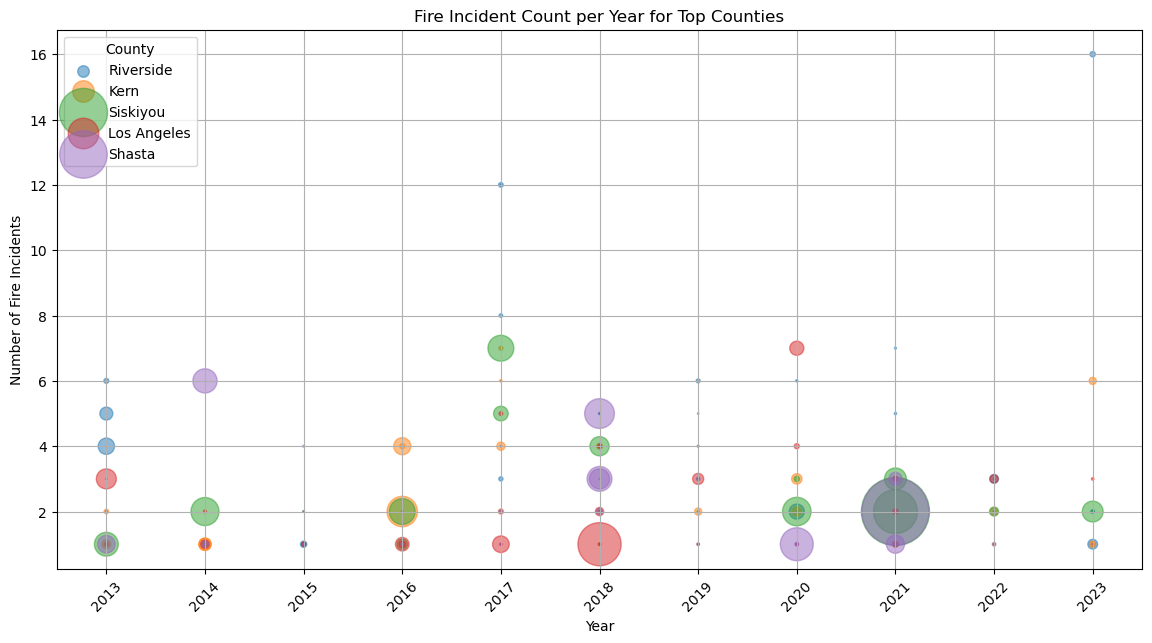

4


In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
years_displayed = []

for county in top_5_counties:
    x_values = top_counties_year.loc[top_counties_year['County'] == county, 'Year'].tolist()
    y_values = top_counties_year.loc[top_counties_year['County'] == county, 'Incident Count Tot'].tolist()
    size = top_counties_year.loc[top_counties_year['County'] == county, 'Acres Burned Avg']/50
    plt.scatter(x_values, y_values, s=size, label=county, alpha=.5)
    years_displayed.extend(x_values)

plt.title('Fire Incident Count per Year for Top Counties')
plt.xlabel('Year')
plt.ylabel('Number of Fire Incidents')
plt.xticks(sorted(set(years_displayed)), rotation = 45)
plt.annotate("Size of marker is scaled with average acres burned.", xy=(2013,-2))
plt.legend(title='County')
plt.grid(True)
plt.show()
print(x)


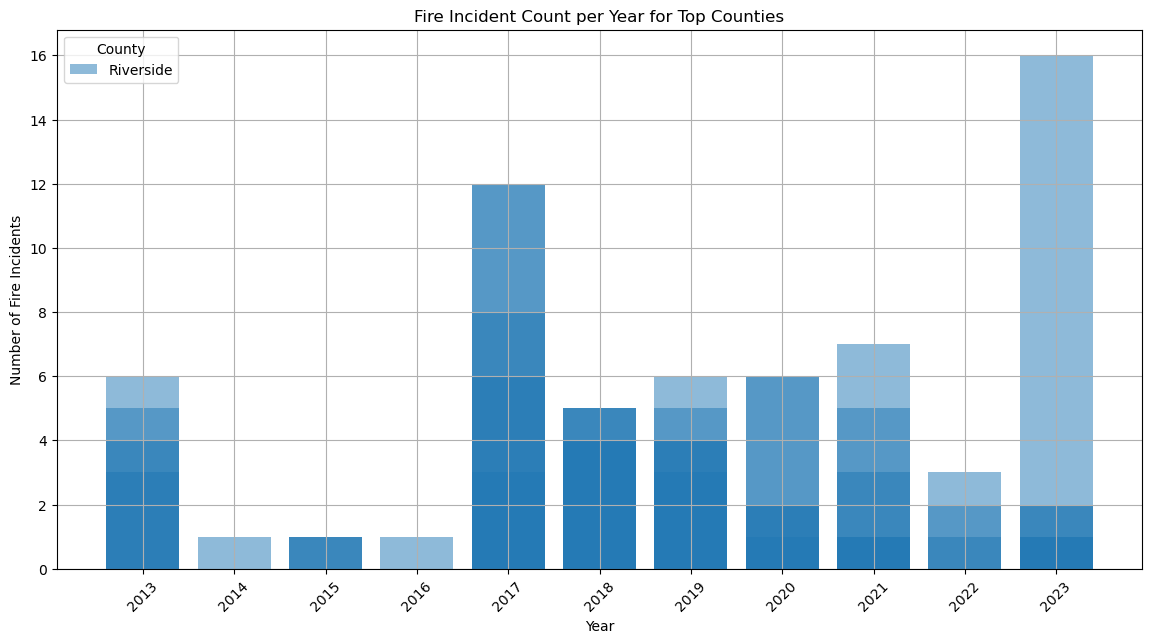

Ventura


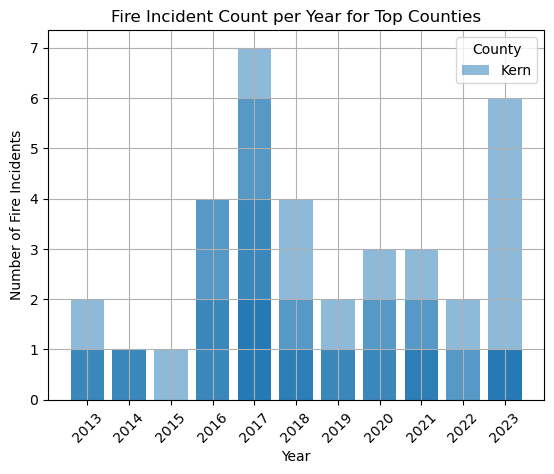

Ventura


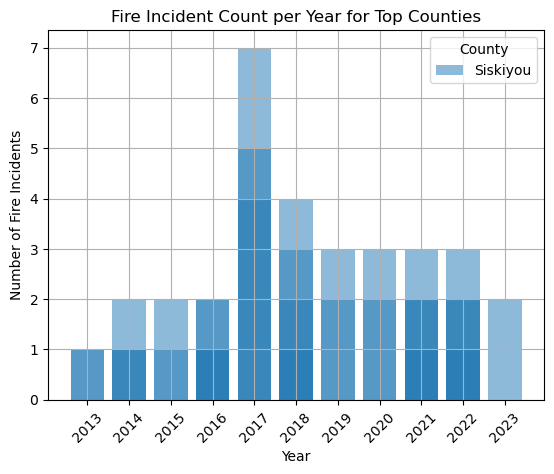

Ventura


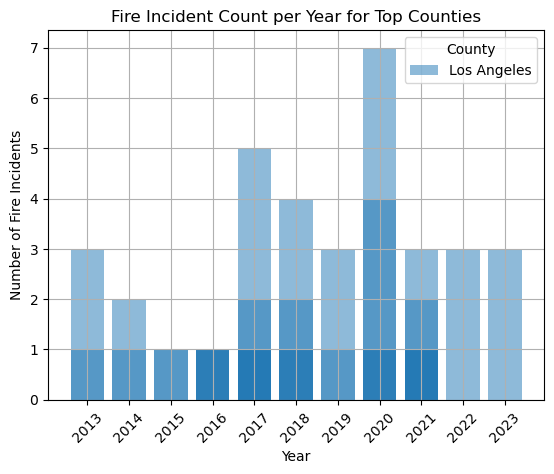

Ventura


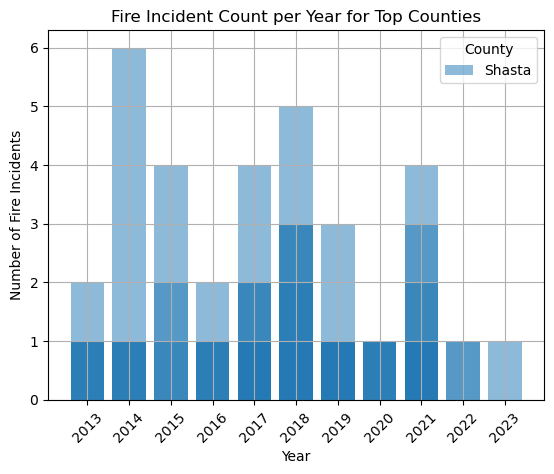

Ventura


In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
years_displayed = []

for county in top_5_counties:
    x_values = top_counties_year.loc[top_counties_year['County'] == county, 'Year'].tolist()
    y_values = top_counties_year.loc[top_counties_year['County'] == county, 'Incident Count Tot'].tolist()
    plt.bar(x_values, y_values, label=county, alpha=.5)
    years_displayed.extend(x_values)

    plt.title('Fire Incident Count per Year for Top Counties')
    plt.xlabel('Year')
    plt.ylabel('Number of Fire Incidents')
    plt.xticks(sorted(set(years_displayed)), rotation = 45)
    plt.annotate("Size of marker is scaled with average acres burned.", xy=(2013,-2))
    plt.legend(title='County')
    plt.grid(True)
    plt.show()
    print(x)


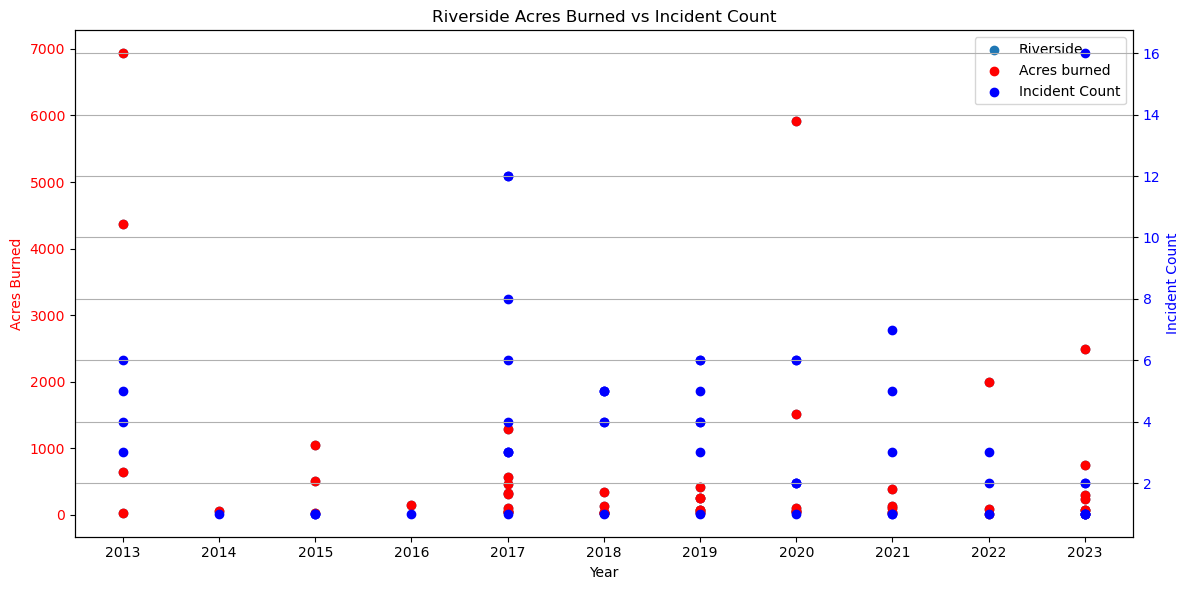

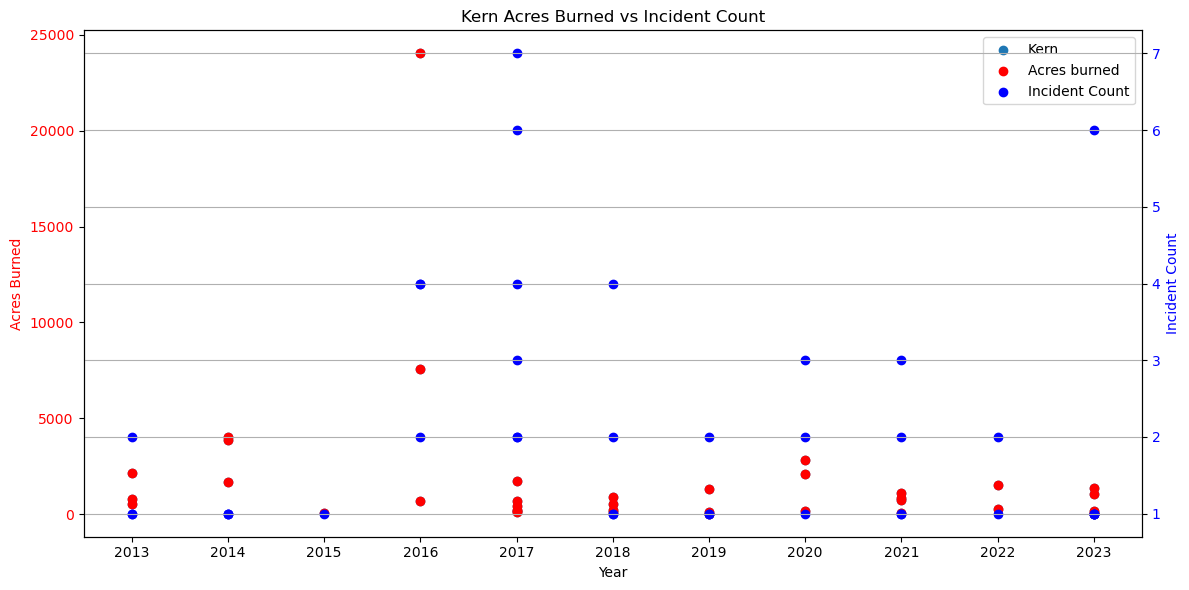

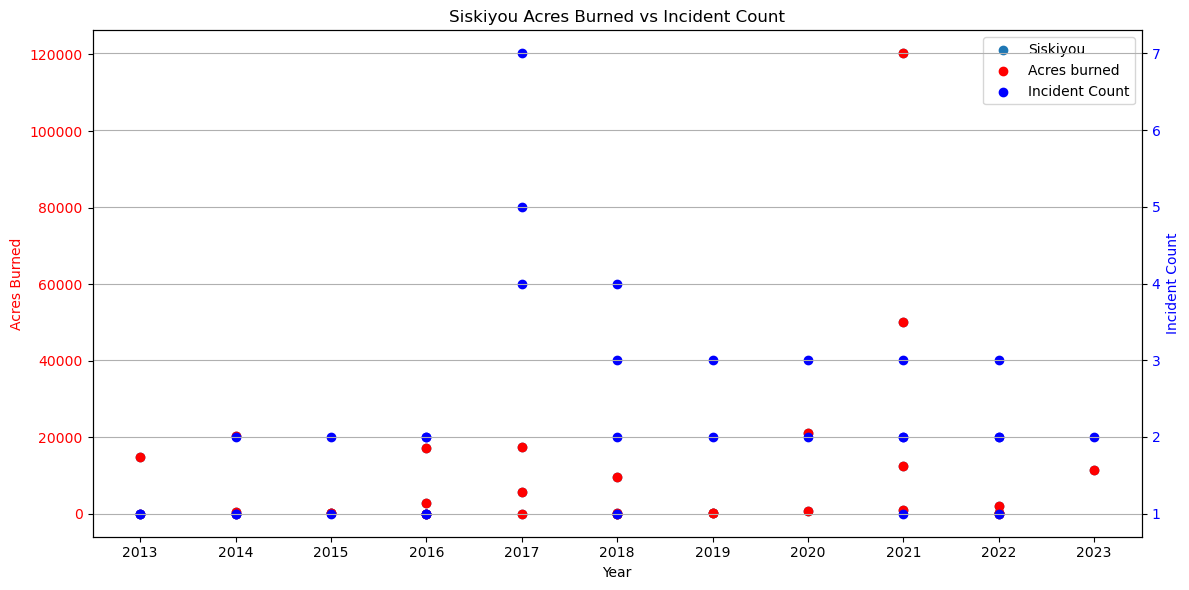

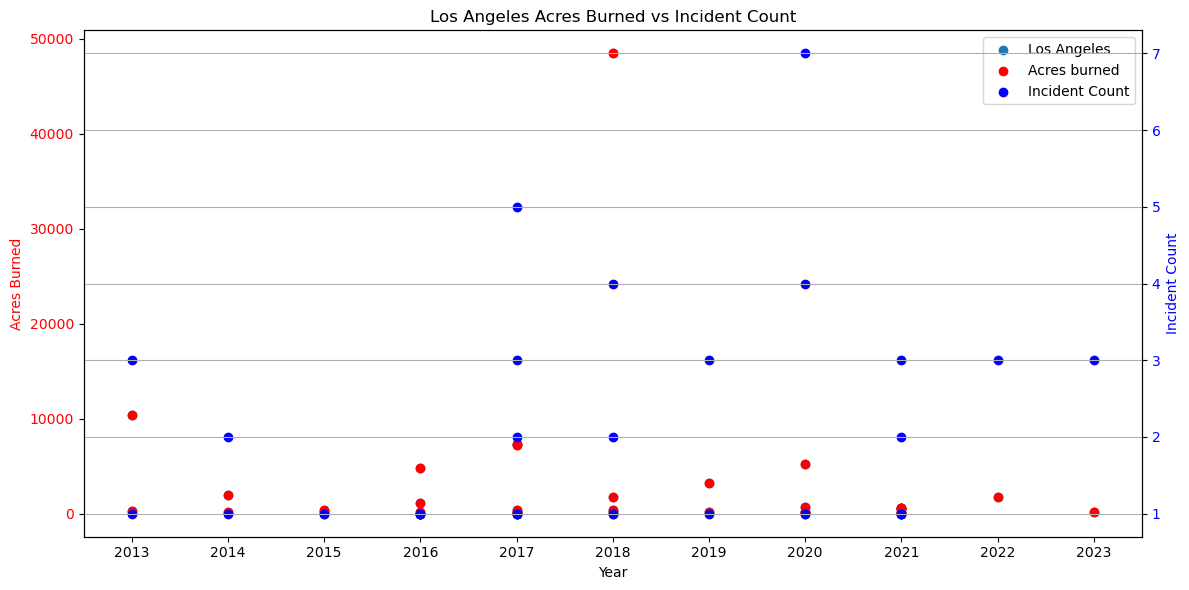

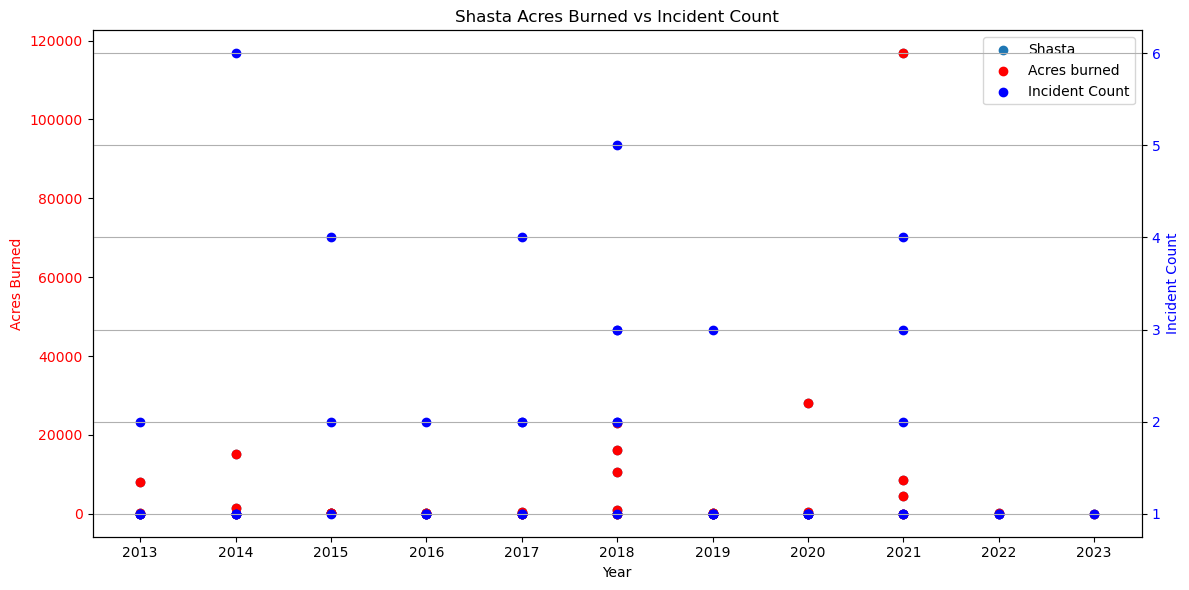

In [31]:
for county in top_5_counties:
    # Create subplots
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    x_values = top_counties_final.loc[top_counties_final['County'] == county, 'Year'].tolist()
    y_values = top_counties_final.loc[top_counties_final['County'] == county, 'Acres Burned Avg'].tolist()
    y2_values = top_counties_final.loc[top_counties_final['County'] == county, 'Incident Count Tot'].tolist()
    plt.scatter(x_values, y_values, label=county)

    # Plotting primary y-axis
    ax1.scatter(x_values, y_values, color='r', marker='o', label='Acres burned')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Acres Burned', color='r')
    ax1.tick_params(axis='y', labelcolor='r')

    # Creating a secondary y-axis
    ax2 = ax1.twinx()
    ax2.scatter(x_values, y2_values, color='b', marker='o', label='Incident Count')
    ax2.set_ylabel('Incident Count', color='b')
    ax2.tick_params(axis='y', labelcolor='b')

    # Adding legend
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    ax1.legend(lines, labels, loc='best')
    
    plt.xticks(sorted(set(years_displayed)), rotation = 45)
    plt.title(f'{county} Acres Burned vs Incident Count')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [32]:
filtered_counties_list = filtered_counties_df["County"].unique().tolist()

In [33]:
county_dfs = {}
for x in filtered_counties_list:
    county_dfs[f'df_{x}'] = filtered_counties_df.loc[(filtered_counties_df["County"] == x)]
    
county_dfs.keys()

dict_keys(['df_Tuolumne', 'df_Los Angeles', 'df_Madera', 'df_Modoc', 'df_Shasta', 'df_Siskiyou', 'df_El Dorado', 'df_Lake', 'df_San Bernardino', 'df_Tulare', 'df_Butte', 'df_Humboldt', 'df_Kern', 'df_Monterey', 'df_Placer', 'df_Santa Barbara', 'df_Santa Clara', 'df_Fresno', 'df_Riverside', 'df_Lassen', 'df_Mariposa', 'df_Plumas', 'df_San Luis Obispo', 'df_Trinity', 'df_Contra Costa', 'df_Mendocino', 'df_San Diego', 'df_Stanislaus', 'df_Napa', 'df_Nevada', 'df_Solano', 'df_Sonoma', 'df_Calaveras', 'df_Alameda', 'df_Colusa', 'df_Inyo', 'df_Tehama', 'df_Glenn', 'df_Merced', 'df_Orange', 'df_San Benito', 'df_San Joaquin', 'df_Yolo', 'df_Ventura'])

In [34]:
calc_cols = ["Acres Burned Avg", "Fire Duration Avg (days)", "Incident Count Tot","Rainfall (inches)"]
stats = [] # for loop
stat_plot = [] # to append 

# for y in county_dfs:
for county in county_dfs:
# Create empty list to fill
    #filter for specific county df and col calculation
    df = county_dfs[county]["Acres Burned Avg"]

    quartiles = df.quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = round(upperq-lowerq, 2)

    stats = list(df)

    # Determine outliers using upper and lower bounds
    lower_bound = round(lowerq - (1.5*iqr), 2)
    upper_bound = round(upperq + (1.5*iqr), 2)

    stat_plot.append(stats)

    stat_plot

In [35]:
# # Generate a box plot that shows the distrubution of the tumor volume for each treatment group.
# fig1, ax1 = plt.subplots()
# flierprops = dict(marker= "o", markerfacecolor= "red", markeredgecolor= "black", markersize= "5")
# ax1.boxplot(stat_plot, flierprops=flierprops)
# ax1.set_ylabel('acres burned')
# x_axis = np.arange(1, len(county_dfs)+1)
# tick_locations = []
# plt.subplots_adjust()
# plt.figure(figsize=(500, 100))
# for x in x_axis:
#      tick_locations.append(x)
# plt.xticks(tick_locations, county_dfs, rotation=45)
# plt.show()

In [36]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(14, 7))
# for county in filtered_counties_list:
#     x_values = filtered_counties_df.loc[filtered_counties_df['County'] == county, 'Year'].tolist()
#     y_values = filtered_counties_df.loc[filtered_counties_df['County'] == county, 'Acres Burned Avg'].tolist()
#     plt.plot(x_values, y_values, label=county)

# plt.title('Total Acres Burned per Year by County')
# plt.xlabel('Year')
# plt.ylabel('Acres Burned')
# plt.legend(title='County')
# plt.grid(True)
# plt.show()
# print(x)


In [37]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(14, 7))
# for county in filtered_counties_list:
#     x_values = filtered_counties_df.loc[filtered_counties_df['County'] == county, 'Year'].tolist()
#     y_values = filtered_counties_df.loc[filtered_counties_df['County'] == county, 'Fire Duration Avg (days)'].tolist()
#     plt.plot(x_values, y_values, label=county)

# plt.title('Total Acres Burned per Year by County')
# plt.xlabel('Year')
# plt.ylabel('Acres Burned')
# plt.legend(title='County')
# plt.grid(True)
# plt.show()
# print(x)


In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
for county in top_counties:
    x_values = top_counties_final.loc[top_counties_final['County'] == county, 'Year'].tolist()
    y_values = top_counties_final.loc[top_counties_final['County'] == county, 'Acres Burned Avg'].tolist()
    plt.scatter(x_values, y_values, label=county)

    plt.title('Total Acres Burned per Year by County')
    plt.xlabel('Year')
    plt.ylabel('Acres Burned')
    plt.legend(title='County')
    plt.grid(True)
    plt.show()
    print(x)


NameError: name 'top_counties' is not defined

<Figure size 1400x700 with 0 Axes>

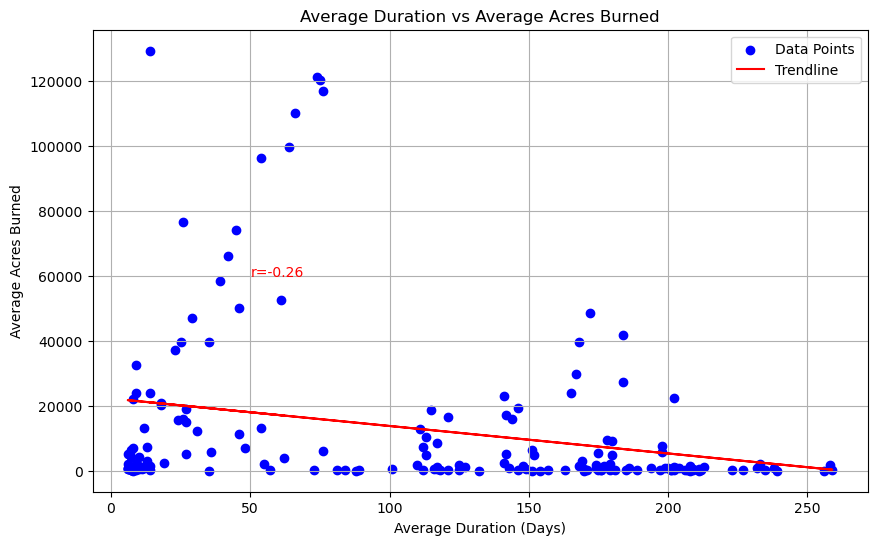

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Data
duration = filtered_counties_df['Fire Duration Avg (days)']
acres_burned = filtered_counties_df['Acres Burned Avg']

# Fit a trendline (linear regression)
result = stats.linregress(duration, acres_burned)
slope, intercept, r = result.slope, result.intercept, "%0.2f"%result.rvalue

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(duration, acres_burned, color='blue', label='Data Points')
plt.plot(duration, slope * duration + intercept, color='red', label='Trendline')

# Labels and title
plt.xlabel('Average Duration (Days)')
plt.ylabel('Average Acres Burned')
plt.title('Average Duration vs Average Acres Burned')
plt.legend()

plt.annotate(f'r={r}', (50, 60000), color="r")

# Show plot
plt.grid(True)
plt.show()

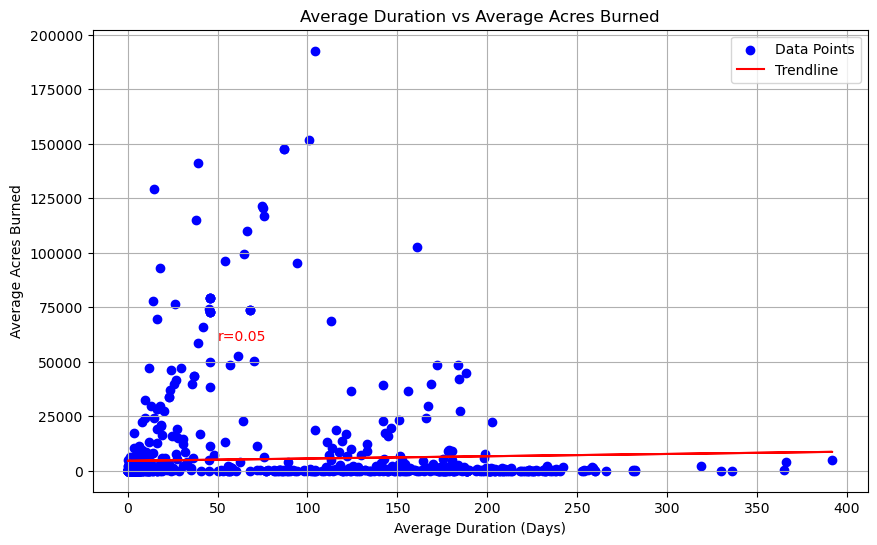

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Data
duration = fire_rain_temp['Fire Duration Avg (days)']
acres_burned = fire_rain_temp['Acres Burned Avg']

# Fit a trendline (linear regression)
result = stats.linregress(duration, acres_burned)
slope, intercept, r = result.slope, result.intercept, "%0.2f"%result.rvalue

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(duration, acres_burned, color='blue', label='Data Points')
plt.plot(duration, slope * duration + intercept, color='red', label='Trendline')

# Labels and title
plt.xlabel('Average Duration (Days)')
plt.ylabel('Average Acres Burned')
plt.title('Average Duration vs Average Acres Burned')
plt.legend()

plt.annotate(f'r={r}', (50, 60000), color="r")

# Show plot
plt.grid(True)
plt.show()

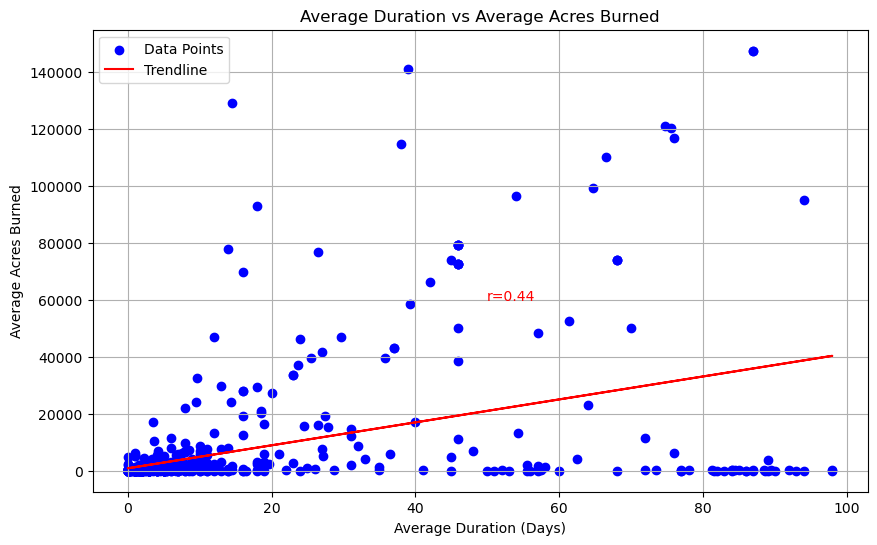

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# fire_rain_temp.dtypes

# Data
duration_less_100_df = fire_rain_temp.loc[fire_rain_temp['Fire Duration Avg (days)']<100]
duration_less_100 = duration_less_100_df["Fire Duration Avg (days)"]

acres_burned = duration_less_100_df['Acres Burned Avg']

# Fit a trendline (linear regression)
result = stats.linregress(duration, acres_burned)
slope, intercept, r = result.slope, result.intercept, "%0.2f"%result.rvalue

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(duration, acres_burned, color='blue', label='Data Points')
plt.plot(duration, slope * duration + intercept, color='red', label='Trendline')

# Labels and title
plt.xlabel('Average Duration (Days)')
plt.ylabel('Average Acres Burned')
plt.title('Average Duration vs Average Acres Burned')
plt.legend()

plt.annotate(f'r={r}', (50, 60000), color="r")

# Show plot
plt.grid(True)
plt.show()